[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aarondomenzain/tracking-softmatter-aarond/blob/tracking-softmatter-aarond-dev/tutorial/detection/detection_spheres.ipynb)

# Particle tracking tutorial: Detection of particles

This tutorial intends to compare different methods for the detection of particles from image files, both from experimental data and simulations. It relies on a number of Python packages, including NumPy, SciKit, Matplotlib, PyTorch, Deeptrack, Deeplay.

In [ ]:
#!pip install deeptrack deeplay trackpy -q #Uncomment if running in google colab

### 1. Initialize all the necessary libraries

In [1]:
import os # Navigate trough directories.
import random # Generate random numbers.
import math # Mathematics library.


import cv2 # opencv (Computer Vision).
import deeptrack as dt # DeepTrack.
import deeplay as dl # Deeplay.
import imageio # Creates images/video from data.
import matplotlib.pyplot as plt # Plotting package.
import numpy as np # Scientific computing using arrays.
import scipy # Optimized for linear algebra and signal processing.
import skimage # Image analysis (scikit).
import tkinter as tk # Package for GUI.
import torch # Import PyTorch library for general neural network applications.
import trackpy as tp  # Particle tracking package. Crocker & Grier method.

Load a set of functions written for this notebook from a utilities file. Thorough documentation of each function is contained in the file.

In [2]:
# Load functions and utilities for dataset generation and visualization.
# Sys append a folder to the path.
sys.path.append("..")

# Import all the functions contained in the utilities file utils.py.
import utils

### 2. Visualization of an experiment
A file selector window will pop up. Select an image containing particles to be visualized.

In [3]:
# Uses tkinter library as tk and tkinter.filedialog.

# Hardcoded path to skip file selector. Not present in final version.
image_path = "JT008_AFM_15.tif"

# Check if an image path has been hardcoded. Otherwise, opens a file selector window. 
# Not present in final version.
try: 
    image_path
except NameError:

# GUI for file selection..
    # Create a root window and hide it (not needed to be displayed).
    root = tk.Tk()
    root.withdraw()

    # Fetch the image file and save the path into a string.
    image_path = tk.filedialog.askopenfilename(title="Select experimental image") 

    # Print the name of the selected file.
    print("Selected file:", image_path)

#### Visualize the loaded image using SciKit 

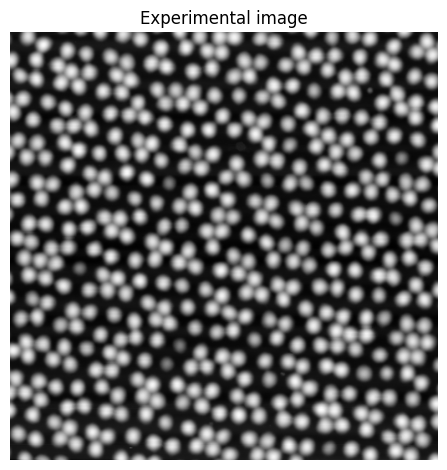

Selected file: JT008_AFM_15.tif
Size of imported image: (512, 512)


In [4]:
# Open a figure instance.
plt.figure()
# Create an instance of the loaded file using SciKit.
image = skimage.io.imread(image_path)

# Crop the image to a square with sides as a power of 2.
image = image[:512, :512]

# Plot the image in grayscale.
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Experimental image")
plt.tight_layout()
plt.show()

print("Selected file:", image_path)
print(f"Size of imported image: {image.shape}")

Manually select and display a single object by specifying its coordinates (x,y).

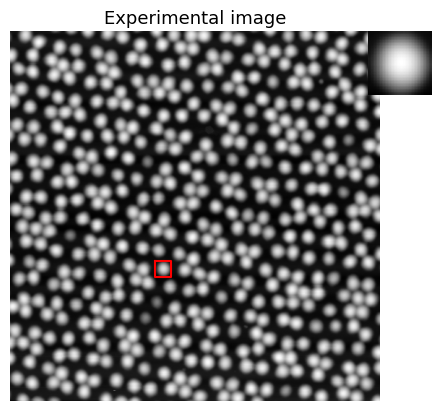

In [5]:
# Window size to zoom in an individual particle.
width = 22 

# Position of the window.
x = 329 - width // 2 
y = 212 - width // 2

# Select a crop as a subset of the entire image.
crop = image[x:x+width, y:y + width]

# Initialize figure instance.
fig = plt.figure()

# Draw a red rectangle around the crop.
fig.add_subplot(111)
plt.imshow(image, cmap='gray')
plt.title("Experimental image", size=13)
plt.plot([y, y+width, y+width, y, y], [x, x, x+width, x+width, x], 'r-')
plt.axis('off')

# Plot the rectangle on the top right corner.
fig.add_subplot(555)
plt.imshow(crop, cmap='gray')
plt.axis('off')
plt.show()

### 3. Use DeepTrack to simulate a realistic image to test the performance of diferent methods. 
DeepTrack can be used to simulate physically realistic scenarios, which can be used to train neural network models.


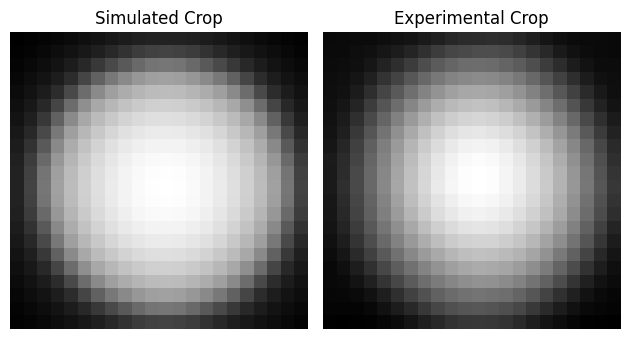

In [6]:
# Same as when selecting a single object.
image_size = width  

particle_radius = 950 # In nm.

# Define central spherical scatterer.
inner_sphere = dt.Sphere(
    position=0.5 * np.array([image_size, image_size]),
    z=-100 * dt.units.nm, # Particle out of focus.
    radius= particle_radius * dt.units.nm,  # Radius in nanometers.
    intensity= 900,  # Field magnitude squared.
)

# Instance containing the scatterer.
combined_sphere = inner_sphere 

# Simulate the properties of the fluorescence microscope.
optics = dt.Fluorescence(
    NA=1.4,  # Numerical aperture.
    wavelength=638. * dt.units.nm, 
    refractive_index_medium=1.33, 
    output_region=[0, 0, image_size, image_size],
    magnification=1,
    resolution=100 * dt.units.nm, # Camera resolution or effective resolution.
    return_field=False,
    )

# Apply transformations to crop.
sim_crop = (
    optics(combined_sphere)
    >> dt.NormalizeMinMax(0.0, 1.0)
    )

# Turn the crop into a NumPy array.
simulated_crop = np.squeeze(sim_crop())

# Plot the simulated and experimental crops.
fig, axes = plt.subplots(1, 2)

# Simulated crop.
plot = axes[0].imshow(simulated_crop, cmap="gray")
axes[0].axis("off")
axes[0].set_title("Simulated Crop")


# Experimental crop.
axes[1].imshow(crop, cmap="gray")  
axes[1].axis("off")
axes[1].set_title("Experimental Crop")

# Adjust layout and show plot.
plt.tight_layout()
plt.show()

### Generate a simulated image to test different detection methods
We generate an image of non-overlapping, spherical particles. First, their coordinates are generated, which are referred to as ground truth positions. Then, we use DeepTrack to place optically realistic particles on such positions.

In [7]:
# Parameters of the simulation.
particle_radius = 9  # Particle radius in pixel units (1 px = 100 nm).
image_size = 256
N_particles = 100


# Generate ground truth positions.
gt_pos = utils.generate_centroids(
    num_particles=N_particles,
    image_size=image_size,
    particle_radius=particle_radius, 
    )

# Simulate image.
simulated_image = utils.transform_to_video(
    gt_pos,
    image_size=image_size,
    core_particle_props={
        "radius": particle_radius * 100 * dt.units.nm,
        "intensity": lambda: 500 * np.random.uniform(0.5, 1.25),
        },
    )

# Generate probability map. if the standard deviation of a Gaussian is 1/3 the
# particle size, the probability of finding the particle within a vecinity of 
# its radius will be 99.7%.
simulated_map = utils.create_probability_map(
    gt_pos, 
    image_size=image_size, 
    sigma=particle_radius / 3, 
    )

Visualize the simulated image and the corresponding probability map. Each probability cloud has a Gaussian profile, with a variance proportional to the radius of the particle.

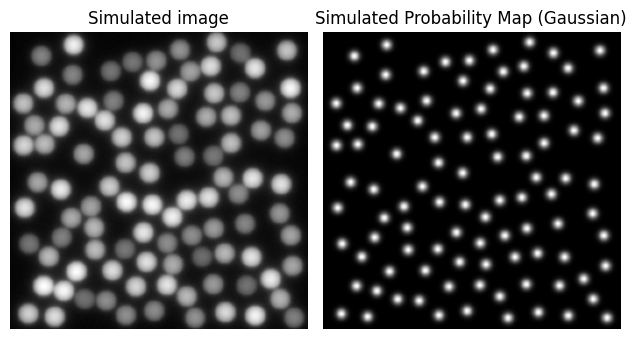

In [8]:
# Create a subfigure instance to plot the image and the probability map.
fig, ax = plt.subplots(1, 2)

# Instance for the simulated experimental image. 
img1 = ax[0].imshow(simulated_image, cmap="gray")
ax[0].axis("off")
ax[0].set_title("Simulated image")  

# Instance for the probability map.
img2 = ax[1].imshow(simulated_map, cmap="gray")
ax[1].axis("off")
ax[1].set_title("Simulated Probability Map (Gaussian)") 

# Adjust layout to avoid overlap.
plt.tight_layout()

# Show the plot.
plt.show()

### 4. Detection and analysis

After generating a realistic simulation of the experiment, we can implement, evaluate and compare different detection algorithms. This is enabled by the fact that the ground truth —i.e., the actual particle positions— is known, allowing for a direct and precise comparison of the detection accuracy.

The following detection methods will be implemented and evaluated with respect to the ground truth:

1. Thresholding (using scikit regionprops)
2. Crocker and Grier (using trackpy)
3. UNet convolutional neural network (using DeepTrack)
4. Lodestar.

## Method 1: Thresholding

In a grayscale image, each point has an intensity value that, when normalized, ranges from 0 to 1, where 1 represents the highest signal intensity arising from particles and values approaching 0 indicate the background in the case of high signal-to-noise ratio (SNR). Thresholding creates a binary mask of the image, setting pixel values to 1 for particles and 0 elsewhere. This is performed by setting a user-defined intensity threshold. Any value above this quantity is round up to 1, else, round down to 0.

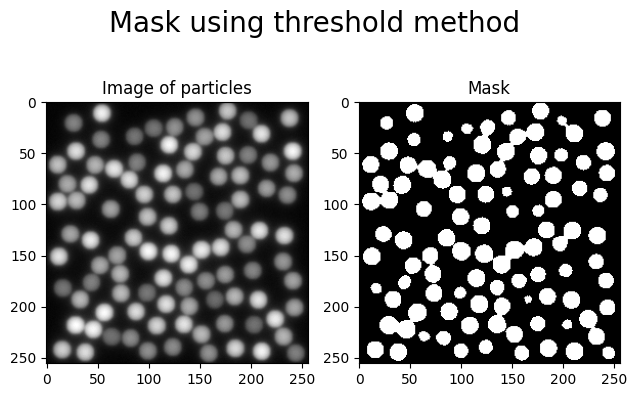

In [9]:
# Minimum value to be considered as unity. 
intensity_threshold = 0.4

# Create the binary mask by applying the threshold.
simulated_mask = simulated_image > intensity_threshold

# Ensure the mask is a 2D array.
simulated_mask = np.squeeze(simulated_mask)

# Plot the image with the calculated mask.
utils.plot_image_mask_probmap(
    image=simulated_image, 
    mask=simulated_mask, 
    title="Mask using threshold method",
)

### Determine the centroids from the mask using Scikit 

In [10]:
# Use the function to extract positions from mask.
detections_M1 = utils.mask_to_positions(simulated_mask)

### Plot the prediction of the centroids from mask

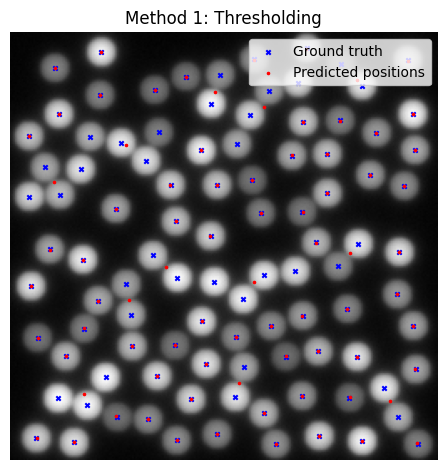

True Positives: 77/100
False Positives: 2
False Negatives: 23
F1 Score: 0.8603
RMSE: 1.0442


In [11]:
# Use the plotting function to compare the detection with the ground truth.
utils.plot_predicted_positions(image=simulated_image, 
                         predicted_positions=detections_M1, 
                         ground_truth_positions=gt_pos, 
                         title="Method 1: Thresholding"
)
utils.evaluate_locs(detections_M1, gt_pos, distance_th=particle_radius);

### Apply the function to evaluate performance the thresholding method
Evaluation metrics are printed: True Positives (TP), False Positives (FP), False Negatives (FN), F1 score (F!) and Mean Square Error (MSE).

In [12]:
# Evaluation metrics can be retrieved if returned outputs are asigned to a variable:
# TP, FP, FN, F1, RMSE = utils.evaluate_locs(detections_M1, gt_pos, distance_th=particle_radius).

utils.evaluate_locs(detections_M1, gt_pos, distance_th=particle_radius);

True Positives: 77/100
False Positives: 2
False Negatives: 23
F1 Score: 0.8603
RMSE: 1.0442


#### Bonus: Use radial symmetry to refine localization
A function is defined in the utility file to exploit the radial symmetry of regions of interest located at the surroundings of previously calculated particle centers. This function works for spherical particles, where the radial symmetry assumption is valid.

Combine radial symmetry with thresholding method for a better estimation of the centroid location.

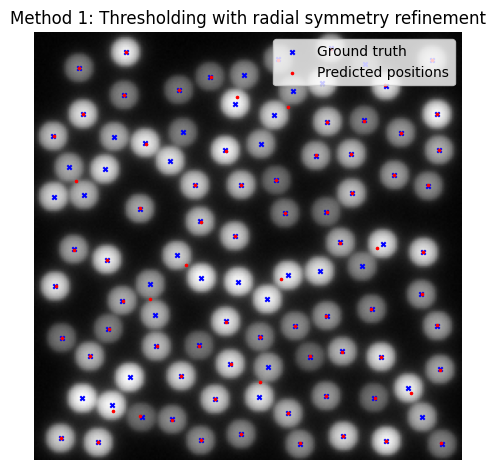

True Positives: 77/100
False Positives: 2
False Negatives: 23
F1 Score: 0.8603
RMSE: 0.9222


In [13]:
# Estimate the location of the centroid of a masked particle optical signal.
detections_M1_ref = utils.locate_particle_centers(
    detections_M1, 
    simulated_image, 
    estimated_radius=particle_radius
)

# Use the plotting function to compare the detection with the ground truth.
utils.plot_predicted_positions(
    image=simulated_image, 
    predicted_positions=detections_M1_ref, 
    ground_truth_positions=gt_pos, 
    title="Method 1: Thresholding with radial symmetry refinement"
)

# Evaluate the performance.
utils.evaluate_locs(detections_M1_ref, gt_pos, distance_th=particle_radius);

### Apply the threshold method to loaded experimental data

No ground truth positions were passed


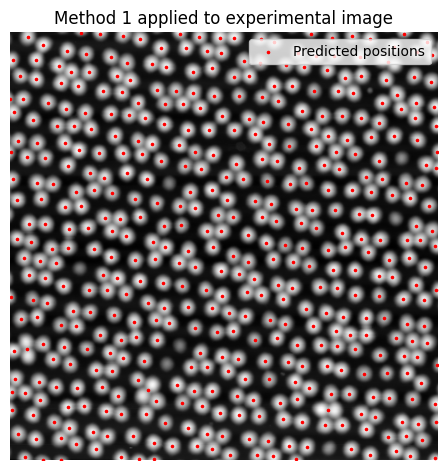

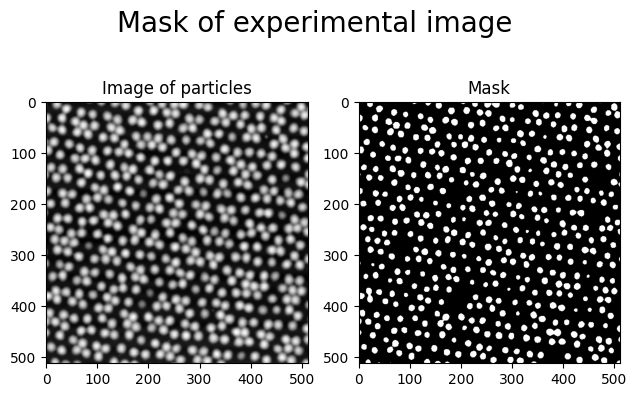

Found 460 detections.


In [14]:
# Normalize the experimental image to have (0,1) intensity values.
image = utils.normalize_min_max(image)

# Intensity threshold for the experimental image.
intensity_threshold_exp = 0.65

# Create the binary mask by applying the threshold.
mask_exp = image > intensity_threshold_exp

# Get predicted positions from the mask.
detections_M1_exp = utils.mask_to_positions(mask_exp)

detections_M1_exp_ref = utils.locate_particle_centers(
    detections_M1_exp,
    image,
    estimated_radius=particle_radius,
)

utils.plot_predicted_positions(
    image=image,
    predicted_positions=detections_M1_exp,
    title="Method 1 applied to experimental image",
)

# Plot the experimental image and the mask.
utils.plot_image_mask_probmap(
    image=image, 
    mask=mask_exp, 
    title="Mask of experimental image",
)

# Print the number of detections.
print(f"Found {len(detections_M1_exp[:,1])} detections.")

## Method 2: Crocker and Grier (using Trackpy)
This method locates Gaussian-like bumps in an intensity map. It requires a user-defined approximate radius which relates to the FWHM of the Gaussian signal. 

The Crocker and Grier method is a built-in function in Tracky. The only user input parameter is the estimated radius in pixel units.

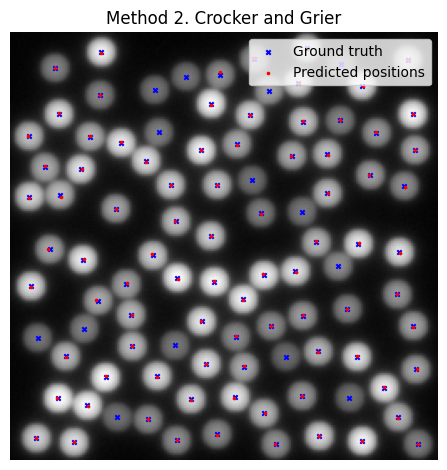

True Positives: 86/100
False Positives: 0
False Negatives: 14
F1 Score: 0.9247
RMSE: 0.7177


In [15]:
# Estimate and tune the diameter of particles in pixels, ensuring it is an
# odd number.
estimated_diameter = 2 * (particle_radius - 0.5)

# Use the locate built-in function from TrackPy.
    # Output is type DataFrame([x, y, mass, size, ecc, signal, raw_mass]).
localizations_dataframe = tp.locate(
    simulated_image, 
    diameter=estimated_diameter, 
    noise_size=4, # Setting for denoising image.
)

# Extract the predicted positions from DataFrame["x","y"] into a NumPy array.
detections_M2 = np.array(localizations_dataframe)[:,:2]

# Plot the prediction and the ground truth.
utils.plot_predicted_positions(
    image=simulated_image,
    predicted_positions=detections_M2,
    ground_truth_positions=gt_pos,
    title="Method 2. Crocker and Grier",
)

# Evaluate the performance of tp.locate.
utils.evaluate_locs(
    detections_M2,
    gt_pos,
    distance_th=particle_radius,
);

### 

## Apply to experimental image

No ground truth positions were passed


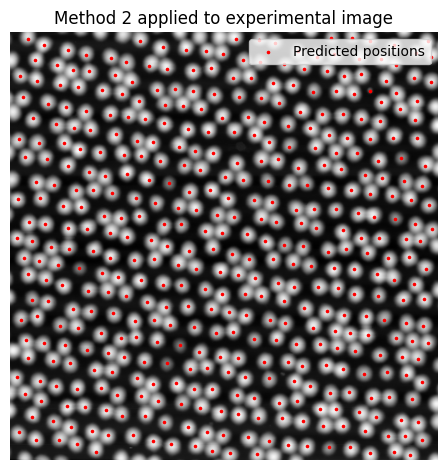

Found 437 detections.


In [16]:
# Use Trackpy.locate to experimental data file 'image'.
localizations_dataframe_exp = tp.locate(
    image, 
    diameter=estimated_diameter - 4, # Tune the estimated diameter at will. 
    invert=False,
    preprocess=True,
)

# Extract the predicted positions from DataFrame["x","y"] into a NumPy array.
detections_M2_exp = np.array(localizations_dataframe_exp)[:,:2]

# Plot the experimental image with predicted positions overlaid.
utils.plot_predicted_positions(
    image=image,
    predicted_positions=detections_M2_exp,
    title="Method 2 applied to experimental image",
)

print(f"Found {len(detections_M2_exp[:,1])} detections.")

## Method 3: UNet

U-Net is a convolutional neural network (CNN), a type of deep learning model, commonly used for image segmentation tasks. It assigns a class label to each pixel in an image, allowing for precise differentiation between the background and objects of interest, from particles to complex cells or anatomical structures, depending on the training. The name "U-Net" comes from its U-shaped architecture, where the encoder (downsampling path) and decoder (upsampling path) are symmetric. The network's bottleneck, located at the center of the U, captures high-level features at reduced spatial resolution, while skip connections preserve fine-grained spatial details.

### Create a training dataset
Simulated images of particles are generated using DeepTrack, along with their corresponding probability maps, which serve as the ground truth.

Load a dataset if available, otherwise, generate it according to the size of the sample and the image size defined by the user.

In [17]:
# Number of samples, image size, and particles.
num_samples = 128
image_size = 64
max_num_particles = 10
force_simulation = False  # Flag to force simulation even if data exists.

# Create path to store training dataset.
folder_name = "UNet"
training_dataset_filename = "UNet_training_dataset_spheres.npz"
training_dataset_folder = folder_name + "/" + "training_data"
training_dataset_filepath = (
    training_dataset_folder + "/" + training_dataset_filename
    )

# Create the enclosing directory if not existent already.
if not os.path.exists(training_dataset_folder):
    os.makedirs(training_dataset_folder, exist_ok=True)

# Dictionaries for shell and core properties. Dimensions are set with lambda
# functions to introduce variety to the dataset.
core_particle_properties = {
    "radius": (
        lambda: np.random.uniform(0.8, 1.2)
        * 100
        * dt.units.nm
        * particle_radius
        ),  # In nm.
    "intensity": lambda: 500 * np.random.uniform(0.75, 1.25),
    }

# Radius and intensity set to zero means no shell.
shell_particle_properties = {
    "radius": 0 * dt.units.nm,
    "intensity": 0,
}

# Try to load preexisting data, if not available or forced, raise the
# exception error to generate new data.
try:
    if force_simulation: 
        # Raise the exception error if simulation is forced.
        raise FileNotFoundError("Forced simulation by user request.")
    
    if not os.path.isfile(training_dataset_filepath):
        # If file is not found, start training.    
        raise FileNotFoundError(
            "Training dataset file not found. Starting simulation."
        )
    
    # Load existing data
    data = np.load(training_dataset_filepath)
    print(f"Loaded file: {training_dataset_filepath}")
    images = data['images']
    maps = data['maps']
    Nsamples = len(images)
        
# Handle the case of either file not found or forced training.
except FileNotFoundError:
    
    # Perform simulation if file not found or forced.
    images, maps = utils.generate_particle_dataset(
        num_samples,
        image_size,
        max_num_particles,
        core_particle_properties,
        shell_particle_properties,
        )
    
    # Save the simulated training dataset.
    np.savez(training_dataset_filepath, images=images, maps=maps)
    print(f"Training dataset saved in: {training_dataset_filepath}.")

Generating sample 6/128

/Users/xdomaa/Desktop/PhD/Particle_Tracking/tracking-softmatter-aarond/spheres/../utils.py:466: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  value = np.asarray(value, dtype=np.float32)
/opt/anaconda3/envs/PT_tutorial_312/lib/python3.12/site-packages/deeptrack/scatterers.py:148: Warning: Scatterer created that is smaller than a pixel. This may yield inconsistent results. Consider using upsample on the scatterer, or upscale on the optics.
  warnings.warn(
/opt/anaconda3/envs/PT_tutorial_312/lib/python3.12/site-packages/scipy/ndimage/_measurements.py:1541: RuntimeWarning: invalid value encountered in scalar divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


Generating sample 128/128
Dataset generation complete.
Training dataset saved in: UNet/training_data/UNet_training_dataset_spheres.npz.
Image dimensions: (128, 64, 64, 1)
Maps dimensions: (128, 64, 64, 1)


Check dimensions of training data. The format to train a U-Net model with Deeplay should be (N,X,Y,C), where:\
\
N: Number of samples (simulated images).\
X: Intensity in the X position.\
Y: Intensity in the Y position.\
C: Color channel (1 for grayscale).

In [19]:
print(f"Image dimensions: {images.shape}")
print(f"Maps dimensions: {maps.shape}")

Image dimensions: (128, 64, 64, 1)
Maps dimensions: (128, 64, 64, 1)


### Visualize the simulated training dataset


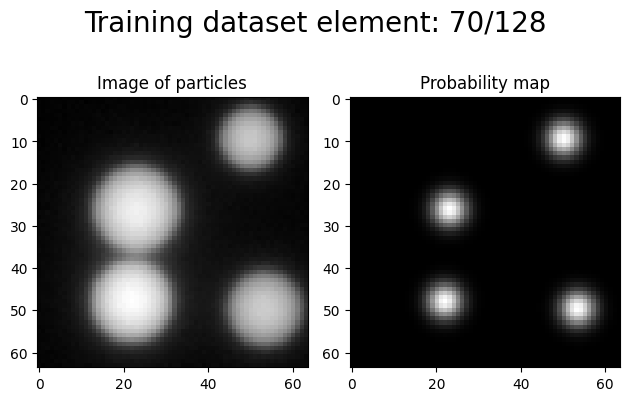

In [20]:
# Select an image and its corresponding probability maps and mask to show.
selected_image_index = np.random.randint(0, len(images))

# Extract the image and probability map from 4D arrays.
selected_image = np.squeeze(images[selected_image_index])
simulated_probability_map = np.squeeze(maps[selected_image_index])

# # Plot the image as the first subplot.
utils.plot_image_mask_probmap(
    image=selected_image,
    probability_map=simulated_probability_map,
    title=f"Training dataset element: {selected_image_index + 1}/{len(images)}",
    )

## Define a U-Net model using Deeplay
The input and output channels of the 2D U-Net are equal to 1, since for the moment we are only analyzing one single color channel corresponding to light intensity in grayscale. We want the U-Net model to be able to recognize a probability map of particles from an experimental image. The single-channel output will then be the spatial probability density.

The U-Net architecture need to be deep enough in order to have a good (reduced) representation of the input image. In order to set the number of convolutional layers N, we use the heuristic argument that N layers, provided with a (default) kernel size of 3x3, enables a (3x3)^N window to look for features in an image. Three layers will enable a 27x27 window, suitable to train a detector of particles with diameters up to 27 pixel units.

In [21]:
# Input and output channels are set to 1, since both images and probability
# maps only have one color channel.
unet = dl.UNet2d(
    in_channels=1, 
    channels=[16, 32, 64], 
    out_channels=1,
)

### Compile the model for the task of regressing the masks from the images

In [22]:
# A U-Net regressor is defined using a deeplay model. The loss function is Mean
# Squared Error Loss, since the output is a continuous intensity map.
unet_reg = dl.Regressor(
    model=unet, 
    loss=torch.nn.MSELoss(), 
    optimizer=dl.Adam(lr=1e-3),
    ).create()

### Define the training pipeline using Deeptrack to generate the training dataset
The training pipeline is composed of the simulated images and the probability maps, together with instructions of value normalization and a selector of images, all of which are instances of Deeplay.

In [23]:
# Image selector
selector = dt.Lambda(
    lambda i: lambda x: x[i],  
    i = lambda l: np.random.randint(l), l=len(images)
)

# Pipeline = simulated images + probability maps + normalization + image selector.
pipeline  = (
    (dt.Value(images) & dt.Value(maps))  
    >> dt.NormalizeMinMax(0,1)  
    >> selector
)

# Create the training dataset instance in PyTorch.
train_dataset = dt.pytorch.Dataset(pipeline, length=256, replace=False)


Check one augmented crop at random

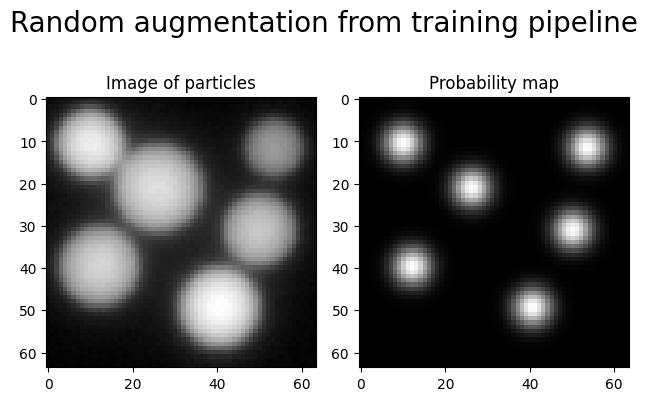

In [24]:
# Sanity check.
sanity_check_pipeline_augmentation = np.squeeze(pipeline.update()())
sanity_check_image_augmentation = sanity_check_pipeline_augmentation[0]
sanity_check_map_augmentation = sanity_check_pipeline_augmentation[1]

# Plot the image as the first subplot.
utils.plot_image_mask_probmap(
    image=sanity_check_image_augmentation,
    probability_map=sanity_check_map_augmentation,
    title=f"Random augmentation from training pipeline",
)

### Train the U-Net model

In [25]:
from torch.utils.data import DataLoader

# Create a DataLoader for training.
train_loader = DataLoader(
    train_dataset, 
    batch_size=16, 
    shuffle=True,
)

# Initialize UNet trainer with automatic accelerator (e.g., CUDA if available).
unet_trainer = dl.Trainer(max_epochs=32, accelerator="auto")

/opt/anaconda3/envs/PT_tutorial_312/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


Tries to load weights if existent. Else, start training and save weights.

In [26]:
# Force training if desired.
force_training = False

# Define the file paths for the model weights.
unet_path = "UNet_model_spheres"
unet_reg_path = "UNet_reg_spheres"

# Define the paths to store files inside the U-Net folder.
unet_path =  folder_name + "/" + unet_path
unet_reg_path = folder_name + "/" + unet_reg_path

# Check if both weight files exist in order to load them.
if os.path.exists(unet_path) and os.path.exists(unet_reg_path):
    
    # Load the dictionaries
    unet.load_state_dict(torch.load(unet_path, weights_only=True))
    unet_reg.load_state_dict(torch.load(unet_reg_path, weights_only=True))
    print(f"Model weights already existent. \
        Loaded successfully from working directory.")

# Starts training if forced or if unet weights are not found in the path.
if force_training or not os.path.exists(unet_path):
    
    # Create the enclosing directory if not existent already.
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)
    
    # Start training with the regressor and the data loader.
    unet_trainer.fit(unet_reg, train_loader)
    
    # Save the pre-trained weights of the U-Net model as Python dictionaries.
    torch.save(unet.state_dict(), unet_path)
    torch.save(unet_reg.state_dict(), unet_reg_path)

/opt/anaconda3/envs/PT_tutorial_312/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MSELoss          │      0 │ train │
│ 1 │ train_metrics │ MetricCollection │      0 │ train │
│ 2 │ val_metrics   │ MetricCollection │      0 │ train │
│ 3 │ test_metrics  │ MetricCollection │      0 │ train │
│ 4 │ model         │ UNet2d           │  128 K │ train │
│ 5 │ optimizer     │ Adam             │      0 │ train │
└───┴───────────────┴──────────────────┴────────┴───────┘

Trainable params: 128 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 128 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 42                                                                                          
Modules in eval mode: 0

Output()

/opt/anaconda3/envs/PT_tutorial_312/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/opt/anaconda3/envs/PT_tutorial_312/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


### Apply the trained U-Net to the simulated image
Select a new image that has not been used for the training to infere the probability map, based on the learning acquired by the U-Net.

In [27]:
# Select an image to apply the learning by the U-Net.
image_of_particles = simulated_image

# Normalize intensity of image to (0,1).
image_of_particles = utils.normalize_min_max(image_of_particles)

# Check the image array shape.
print(f" Shape of selected image: {image_of_particles.shape} ")

# Reshape the array to match the (N, C, X, Y) format.
missing_array_dimensions = 4 - len(image_of_particles.shape)
for missing_dims in range(missing_array_dimensions):
    image_of_particles = np.expand_dims(image_of_particles, axis=0)
    print(f" Shape of selected image after reshaping to match the (N, C, X, Y): {image_of_particles.shape} ")

# Transpose PyTorch array (done to make the simulated image compatible with PyTorch indexing).
if image_of_particles.shape[-1] == 1: # If last element is color channel.
    image_of_particles = image_of_particles.transpose(0, 3, 1, 2)
    print(f" Shape of selected image after transposing to match the (N, C, X, Y): {image_of_particles.shape} ")

 Shape of selected image: (256, 256, 1) 
 Shape of selected image after reshaping to match the (N, C, X, Y): (1, 256, 256, 1) 
 Shape of selected image after transposing to match the (N, C, X, Y): (1, 1, 256, 256) 


Convert the selected image to a PyTorch tensor to infer the probability map of the particles using the learning of the trained U-Net

In [28]:
# Ensure that the image is a numpy array in float32 format.
image_of_particles_array = np.array(image_of_particles).astype(np.float32)

# Convert the image to analyze into a PyTorch tensor.
image_of_particles_tensor = torch.from_numpy(image_of_particles_array)

# Apply the UNet to the loaded image.
pred_maps_tensor = unet_reg(image_of_particles_tensor)

# Convert to NumPy array.
pred_maps_array = pred_maps_tensor[0, 0, :, :].detach().numpy()
image_of_particles = image_of_particles_array[0, 0, :, :]

# Normalize intensity.
pred_maps_array = utils.normalize_min_max(pred_maps_array)

Apply the mask method to the predicted probability map

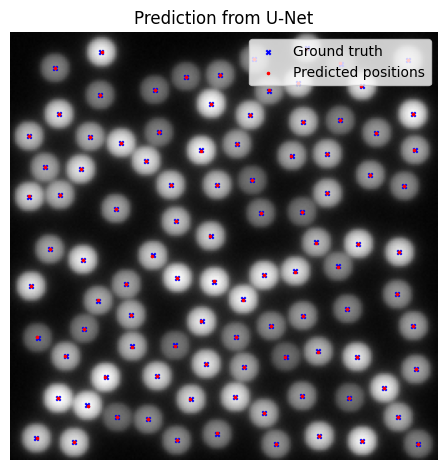

True Positives: 100/100
False Positives: 0
False Negatives: 0
F1 Score: 1.0000
RMSE: 0.4245


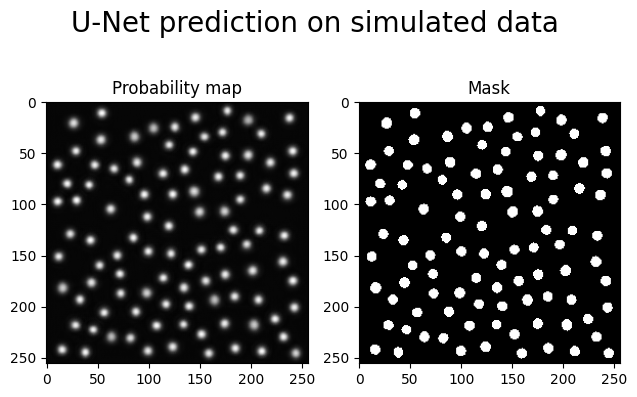

In [29]:
# Apply thresholding to the predicted probability map.
pred_mask_unet = pred_maps_array > 0.25

# Convert the masked probability map to positions.
detections_unet = utils.mask_to_positions(pred_mask_unet)

# Show the predicted posiions overlaid with the ground truth on the simulated
# image.
utils.plot_predicted_positions(
    image=image_of_particles_array,
    predicted_positions=detections_unet, 
    ground_truth_positions=gt_pos,
    title="Prediction from U-Net",
)

# Measure the performance.
utils.evaluate_locs(
    detections_unet,
    gt_pos,
    distance_th=particle_radius,
)

#Plot the predicted probability map and its masked version.
utils.plot_image_mask_probmap(
    mask=pred_mask_unet,
    probability_map=pred_maps_array,
    title="U-Net prediction on simulated data",
)

### Apply the trained U-Net to the experimental image


No ground truth positions were passed


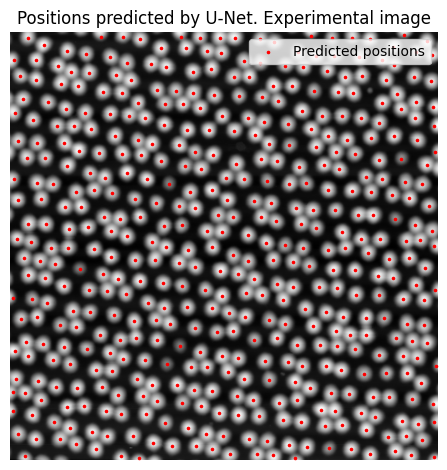

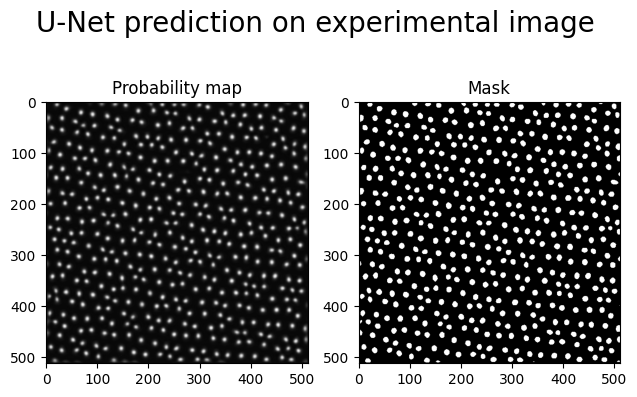

Found 464 detections.


In [30]:
# Normalize intensity of image to (0,1).
image_of_particles_exp = utils.normalize_min_max(image)

# Reshape the array to match the (N, C, X, Y) format.
image_of_particles_exp = image_of_particles_exp[np.newaxis, np.newaxis, ...]

# Ensure that the image is a numpy array.
image_of_particles_exp = np.array(image_of_particles_exp).astype(np.float32) 

# Convert the image to analyze into a PyTorch tensor.
image_of_particles_exp_tensor = torch.from_numpy(image_of_particles_exp)

# Apply the UNet to the loaded image.
pred_maps_unet_exp = unet_reg(image_of_particles_exp_tensor)

# Convert the prediction to a NumPy array for easy plotting.
pred_maps_unet_exp_array = pred_maps_unet_exp[0, 0, :, :].detach().numpy()

# Normalize intensity to (0,1).
pred_maps_unet_exp_array = utils.normalize_min_max(pred_maps_unet_exp_array)

# Calculate a mask from the probability map with thresholding method.
pred_mask_unet_exp = pred_maps_unet_exp_array > 0.2

# Extract the positions from the mask.
detections_unet_exp = utils.mask_to_positions(pred_mask_unet_exp)

# Plot the experimental image with the positions predicted by U-Net.
utils.plot_predicted_positions(
    image=image, 
    predicted_positions=detections_unet_exp,
    title="Positions predicted by U-Net. Experimental image",
)

#Plot the predicted probability map and its masked version.
utils.plot_image_mask_probmap(
    mask=pred_mask_unet_exp,
    probability_map=pred_maps_unet_exp_array,
    title="U-Net prediction on experimental image",
)

print(f"Found {len(detections_unet_exp[:, 1])} detections.")

## Method 4: LodeSTAR
LodeSTAR is a self-supervised object detection method that can be trained using a single input image.\
LodeSTAR will be trained with simulated crops to measure its performance on simulated data and then experimental data. The same idea will be applied to train LodeSTAR with experimental crops.

### Initiate a training pipeline with only one simulated crop.
We can apply augmentations to the same crop to increase the diversity of the dataset.

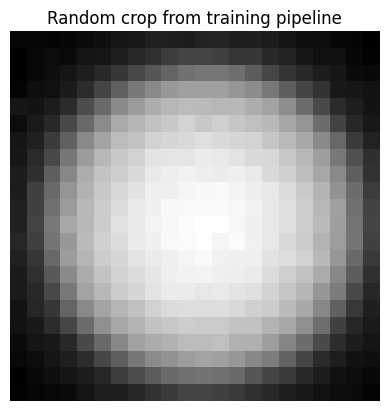

In [31]:
# Use the same simulated crop from the beginning of this tutorial.
# Match the (N,C,X,Y) format for training images with PyTorch.
simulated_crop_tensor = simulated_crop[:, :, np.newaxis]

# Define the training pipeline with additional settings, such as multiplication
# of global intensity and Gaussian noise.
training_pipeline = (
    dt.Value(simulated_crop_tensor)
    >> dt.NormalizeMinMax(0.0, 0.95)
    >> dt.Gaussian(0.0, 0.01)
    >> dt.Multiply(lambda: np.random.uniform(0.75, 1.0))
    >> dt.MoveAxis(-1, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)

# Build a training dataset with a pipeline that randomly selects a crop each
# time.
train_dataset = dt.pytorch.Dataset(
    training_pipeline,
    length=512,
)

# Dataloader contains the randomized training dataset and additional settings.
dataloader = dl.DataLoader(
    train_dataset,
    batch_size=16,
)

# We can check one of the elements in the training pipeline with augmentations.
sanity_check_crop = training_pipeline.update()()
plt.imshow(np.squeeze(sanity_check_crop), cmap="gray")
plt.title("Random crop from training pipeline")
plt.axis("off")
plt.show()

### Initiate the LodeSTAR model and the trainer

In [32]:
#  Initialize the model.
lodestar = dl.LodeSTAR(
    n_transforms=8, 
    optimizer=dl.Adam(lr=1e-3), 
).build()

# Set up the trainer and specify number of epochs.
trainer_lodestar = dl.Trainer(max_epochs=16)

### Load pre-trained weights or generate new weights.
To save time, if you have already run the training you can load pre-existing weights.

In [33]:
force_training = False

# File name of pre-trained weights.
lodestar_path = "lodestar_weights_simulated"

# Define the name of an enclosing folder and add it to the file path.
folder_name = "LodeSTAR"
lodestar_path =  folder_name + "/" + lodestar_path

#  Check if weights exist or if training will be forced.
if not os.path.isfile(lodestar_path) or force_training:
    
    # Create the enclosing directory if not existent already.
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)
    
    #  Start training.
    trainer_lodestar.fit(lodestar, dataloader)
    torch.save(lodestar.state_dict(),lodestar_path)
else:
    
    #  Load pre-existing weights.
    lodestar.load_state_dict(
        torch.load(
            lodestar_path,
            weights_only=True,
        )
    )
    print("Loaded preexisting LodeSTAR weights trained on simulated data.")

# Switch the model to evaluation mode.
lodestar.eval();

/opt/anaconda3/envs/PT_tutorial_312/lib/python3.12/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:477: The total number of parameters detected may be inaccurate because the model contains an instance of `UninitializedParameter`. To get an accurate number, set `self.example_input_array` in your LightningModule.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type                       ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model         │ ConvolutionalNeuralNetwork │  251 K │ train │
│ 1 │ between_loss  │ L1Loss                     │      0 │ train │
│ 2 │ within_loss   │ L1Loss                     │      0 │ train │
│ 3 │ train_metrics │ MetricCollection           │      0 │ train │
│ 4 │ val_metrics   │ MetricCollection           │      0 │ train │
│ 5 │ test_metrics  │ MetricCollection           │      0 │ train │
│ 6 │ optimizer     │ Adam                       │      0 │ train │
└───┴───────────────┴────────────────────────────┴────────┴───────┘

Trainable params: 251 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 251 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 39                                                                                          
Modules in eval mode: 0

Output()

/opt/anaconda3/envs/PT_tutorial_312/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


With the training complete, we are now ready to benchmark the performance by predicting the positions on simulated data, where the ground truth is known.

In [34]:
# Parameters for inference.
alpha = 0.05
beta = 1 - alpha
cutoff = 0.0005

# Extract predictions.
prediction = lodestar(image_of_particles_tensor).squeeze().detach()

# Extract the mass feature from the prediction.
mass_feature = prediction[2]

# Infer on the pytorch image.
detections_lodestar = lodestar.detect(
    image_of_particles_tensor,
    alpha = alpha,
    beta = beta, 
    mode = "constant",
    cutoff = cutoff,
)[0]
                         
print(f"Found {len(detections_lodestar[:, 1])} detections.")

Found 101 detections.


### Display predictions from the simulated image

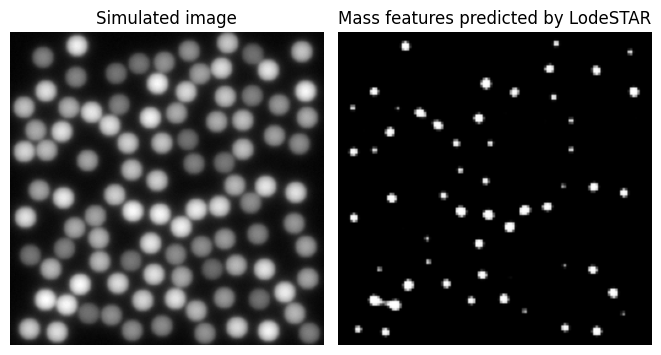

In [35]:
plt.figure(figsize=(10, 5))

#  Subfigure 1, test image.
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(simulated_image), cmap="gray")
plt.axis("off")
plt.title("Simulated image")

#  Subfigure 2, mass feature distribution.
plt.subplot(1, 3, 2)
plt.imshow(mass_feature, cmap="gray")
plt.axis("off")
plt.title("Mass features predicted by LodeSTAR")

plt.axis("off")
plt.tight_layout()
plt.show()

### Overlay detections to simulated image
Measure the detection accuracy by contrasting with the ground truth of positions.

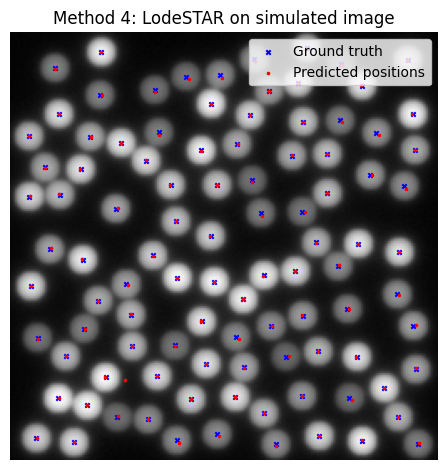

True Positives: 100/100
False Positives: 1
False Negatives: 0
F1 Score: 0.9950
RMSE: 0.8050


In [36]:
# Plot the predicted positions and the ground truth overlaid on the simulated
# image.
utils.plot_predicted_positions(
    image=simulated_image,
    predicted_positions=detections_lodestar,
    ground_truth_positions=gt_pos,
    title="Method 4: LodeSTAR on simulated image",
)
#  Evaluate performance.
utils.evaluate_locs(detections_lodestar, gt_pos, distance_th=particle_radius);

We can apply LodeSTAR trained on simulated data to predict the positions on the experimental image.

Found 476 detections.


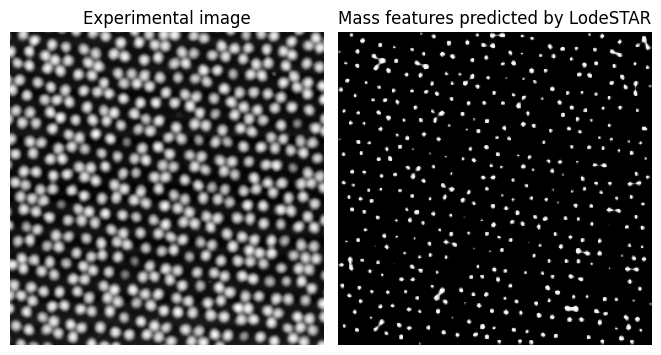

In [37]:
#  Parameters for inference.
alpha = 0.05
beta = 1 - alpha
cutoff = 0.001
#  Extract predictions and convert into a tensor
prediction_exp = lodestar(image_of_particles_exp_tensor).squeeze().detach()

# Extract the mass feature from the prediction
mass_feature_exp = prediction_exp[2]

#  Infer positions from experimental image.
detections_lodestar_experimental = lodestar.detect(
    image_of_particles_exp_tensor,
    alpha = alpha,
    beta = beta, 
    mode = "constant",
    cutoff = cutoff,
)[0]
                         
print(f"Found {len(detections_lodestar_experimental[:,1])} detections.")
### Display predictions of experimental image
# Set the figure size
plt.figure(figsize=(10, 5))

#  Subfigure 1, test image.
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(image_of_particles_exp), cmap="gray")
plt.axis("off")
plt.title("Experimental image")

#  Subfigure 2, probability distribution.
plt.subplot(1, 3, 2)
plt.imshow(mass_feature_exp, cmap="gray")
plt.axis("off")
plt.title("Mass features predicted by LodeSTAR")

plt.gca().set_aspect('equal', adjustable='box')
plt.axis("off")
plt.tight_layout()
plt.show()

Overlay the predicted positions on the experimental image.

No ground truth positions were passed


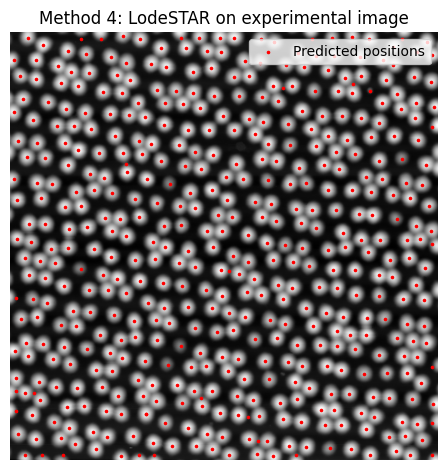

Found 476 detections.


In [38]:
utils.plot_predicted_positions(
   image=image_of_particles_exp[0, 0, :, :],
   predicted_positions= detections_lodestar_experimental,
   title="Method 4: LodeSTAR on experimental image"
)
print(f"Found {len(detections_lodestar_experimental[:,1])} detections.")

### Training using experimental crops instead of simulated data.
Since LodeSTAR is a self-supervised neural network, we can train it with experimental crops instead of simulations. By analyzing the image, we extract the coordinate pairs corresponding to characteristic particles.

Initiate the training pipeline with experimental crops.

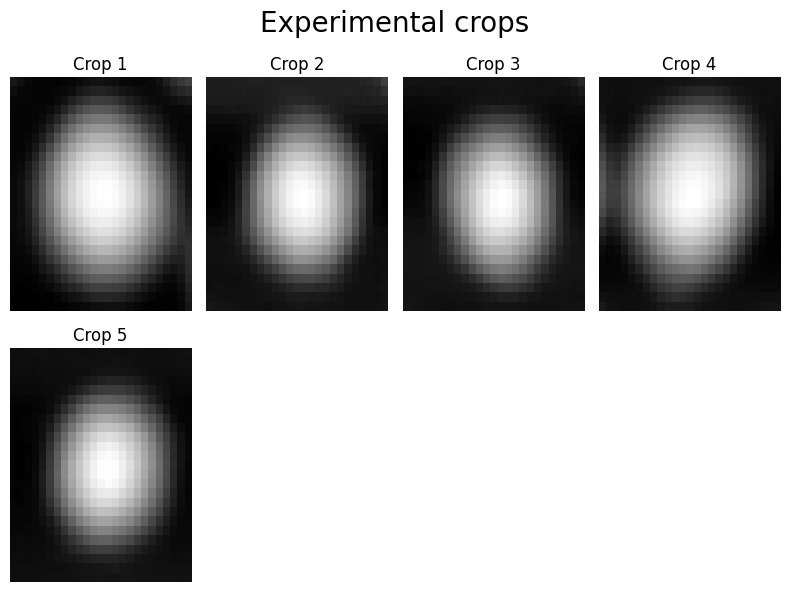

In [39]:
# Get coordinates from relevant crop samples.
xs = [230, 168, 362, 330, 138]
ys = [272, 177, 190, 435, 455]
number_of_crops = len(xs)

# Pre-allocate array to store all the crops.
training_images = []
for i in range(number_of_crops):
    # Go through the locations of the crops in the image.
    y_index = ys[i]
    x_index = xs[i]
    crop_size = 25

    # Crop a window in the image.
    x0 = x_index
    y0 = y_index
    training_image = np.array(image[x0:x0 + crop_size, y0: y0 + crop_size])

    # Expand dims with np.newaxis and append to list.
    training_images.append(training_image[np.newaxis, ...])
plt.show()

# Plot up to 18 simulated crops.
utils.plot_crops(np.squeeze(training_images), title="Experimental crops")

Prepare the training pipeline with the selected experimental crops.

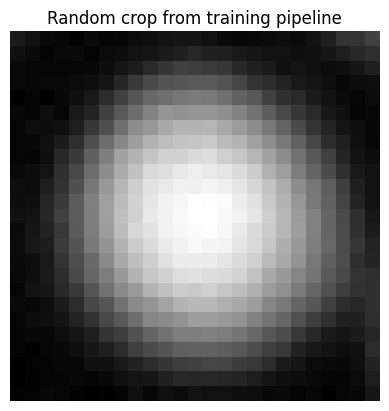

In [40]:
# Random selector of crops.
random_crop = lambda: random.choice(training_images)

# Define training pipeline.
training_pipeline = (
    dt.Value(random_crop)
    >> dt.NormalizeMinMax(0.0, 0.95)
    >> dt.Gaussian(0.0, 0.01)
    >> dt.Multiply(lambda: np.random.uniform(0.75, 1.0))
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)

# Build a training dataset with a pipeline that randomly selects a crop each
# time.
train_dataset = dt.pytorch.Dataset(
    training_pipeline,
    length=512,
)

# Dataloader contains the randomized training dataset and additional settings.
dataloader = dl.DataLoader(
    train_dataset,
    batch_size=16,
)

# We can check one of the elements in the training pipeline with augmentations.
sanity_check_crop = training_pipeline.update()()
plt.imshow(np.squeeze(sanity_check_crop), cmap="gray")
plt.title("Random crop from training pipeline")
plt.axis("off")
plt.show()

### Initiate the LodeSTAR model and the trainer

In [41]:
#  Initialize the model as a Deeplay instance.
lodestar_exp = dl.LodeSTAR(
    n_transforms=8, 
    optimizer=dl.Adam(lr=1e-3),
).build()

# Initialize the trainer.
trainer_lodestar_exp = dl.Trainer(max_epochs=32)

#print(model)

### Load pre-trained weights or generate new weights.
To save time, if you have already run the training you can load pre-existing weights.

In [42]:
force_training = False

# File name of pre-trained weights.
lodestar_exp_path = "lodestar_weights_exp"

# Define the name of an enclosing folder and add it to the file path.
folder_name = "LodeSTAR"
lodestar_exp_path =  folder_name + "/" + lodestar_exp_path

#  Check if weights exist.
if not os.path.isfile(lodestar_exp_path) or force_training:
    
    # Create the enclosing directory if not existent already.
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)

    #  Start training.
    trainer_lodestar_exp.fit(lodestar_exp, dataloader)
    torch.save(lodestar_exp.state_dict(), lodestar_exp_path)
else:
    #  Load pre-existing weights.
    lodestar_exp.load_state_dict(
        torch.load(
            lodestar_exp_path,
            weights_only=True,
        )
    )
    print("Loaded preexisting LodeSTAR weights trained on experimental data")

# Switch the model to evaluation mode.
lodestar_exp.eval();

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type                       ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model         │ ConvolutionalNeuralNetwork │  251 K │ train │
│ 1 │ between_loss  │ L1Loss                     │      0 │ train │
│ 2 │ within_loss   │ L1Loss                     │      0 │ train │
│ 3 │ train_metrics │ MetricCollection           │      0 │ train │
│ 4 │ val_metrics   │ MetricCollection           │      0 │ train │
│ 5 │ test_metrics  │ MetricCollection           │      0 │ train │
│ 6 │ optimizer     │ Adam                       │      0 │ train │
└───┴───────────────┴────────────────────────────┴────────┴───────┘

Trainable params: 251 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 251 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 39                                                                                          
Modules in eval mode: 0

Output()

### Infer on experimental image

In [46]:
#  Parameters for inference.
alpha = 0.1
beta = 1 - alpha 
cutoff = 0.01
#  Extract predictions and convert into a tensor.
prediction_exp = lodestar_exp(image_of_particles_exp_tensor).squeeze().detach()

# Extract the mass feature from the prediction.
mass_feature_exp = prediction_exp[2]

#  Infer positions from experimental image.
detections_lodestar_experimental = lodestar_exp.detect(
    image_of_particles_exp_tensor,
    alpha=alpha,
    beta=beta, 
    mode="constant",
    cutoff=cutoff,
)[0]
                         
print(f"Found {len(detections_lodestar_experimental[:,1])} detections.")

Found 460 detections.


### Display predictions of experimental image

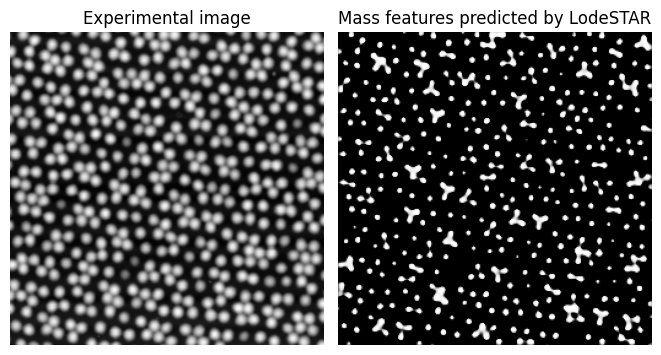

In [47]:
# Set the figure size.
plt.figure(figsize=(10, 5))

#  Subfigure 1, test image.
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(image_of_particles_exp), cmap="gray")
plt.axis("off")
plt.title("Experimental image")

#  Subfigure 2, mass feature distribution.
plt.subplot(1, 3, 2)
plt.imshow(mass_feature_exp, cmap="gray")
plt.axis("off")
plt.title("Mass features predicted by LodeSTAR")

plt.gca().set_aspect('equal', adjustable='box')
plt.axis("off")
plt.tight_layout()
plt.show()

Overlay the predicted positions on the experimental image

No ground truth positions were passed


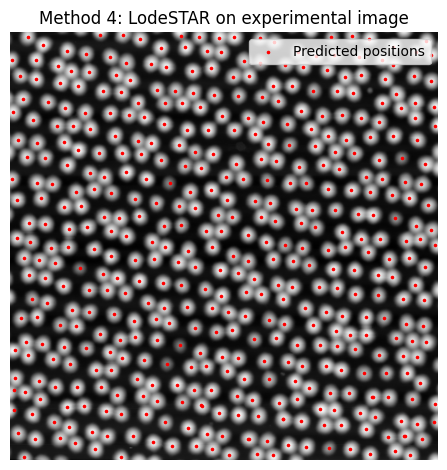

In [48]:
utils.plot_predicted_positions(
   image=image_of_particles_exp[0, 0, :, :],
   predicted_positions= detections_lodestar_experimental,
   title="Method 4: LodeSTAR on experimental image"
)